In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

In [2]:
import numpy as np
import torch
from torch import nn
from scipy.stats import lognorm
from matplotlib import pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from tqdm import tqdm

In [3]:
#integration parameter
INTERVAL_LENGTH = 10
START_UNIF = 0.01
SCALING_CONSTANT = 10000

In [4]:
options = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")
print(options.columns)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['DateCode', 'Date', 'OptionsCode', 'WholeDayOpen', 'WholeDayHigh',
       'WholeDayLow', 'WholeDayClose', 'NightSessionOpen', 'NightSessionHigh',
       'NightSessionLow', 'NightSessionClose', 'DaySessionOpen',
       'DaySessionHigh', 'DaySessionLow', 'DaySessionClose', 'TradingVolume',
       'OpenInterest', 'TradingValue', 'ContractMonth', 'StrikePrice',
       'WholeDayVolume', 'Putcall', 'LastTradingDay', 'SpecialQuotationDay',
       'SettlementPrice', 'TheoreticalPrice', 'BaseVolatility',
       'ImpliedVolatility', 'InterestRate', 'DividendRate', 'Dividend'],
      dtype='object')


In [5]:
options.head()

,DateCode,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,...,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
0,20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,480.0,478.4587,17.4736,17.5865,0.0091,0.0,0.0
1,20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,575.0,571.1385,17.4736,16.5000,0.0091,0.0,0.0
2,20170104_132010218,2017-01-04,132010218,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,680.0,677.3710,17.4736,15.8644,0.0091,0.0,0.0
3,20170104_132010318,2017-01-04,132010318,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,795.0,791.0383,17.4736,15.2288,0.0091,0.0,0.0
4,20170104_132010518,2017-01-04,132010518,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,910.0,909.9947,17.4736,14.5932,0.0091,0.0,0.0


In [6]:
options[['Date','LastTradingDay']]

,Date,LastTradingDay
0,2017-01-04,20170112
1,2017-01-04,20170112
2,2017-01-04,20170112
3,2017-01-04,20170112
4,2017-01-04,20170112
...,...,...
3567689,2021-12-03,20241212
3567690,2021-12-03,20241212
3567691,2021-12-03,20241212
3567692,2021-12-03,20241212


In [7]:
pd.set_option('display.max_columns', None)
dataset = options.loc[(options['LastTradingDay'] == 20170112)& (options['WholeDayVolume']> 0) & (options['Date'] == '2017-01-04')][['StrikePrice', 'Putcall', 'SettlementPrice']]#[['WholeDayClose', 'SettlementPrice']]
dataset[['StrikePrice', 'SettlementPrice']] = dataset[['StrikePrice', 'SettlementPrice']].transform(lambda x : x/SCALING_CONSTANT)
dataset['Putcall'] = dataset['Putcall'].transform(lambda x : False if x==1 else True)

In [8]:
dataset

,StrikePrice,Putcall,SettlementPrice
0,2.0000,False,0.0480
18,1.3000,False,0.0001
25,1.4500,False,0.0001
26,1.4625,False,0.0001
27,1.4750,False,0.0001
...,...,...,...
894,1.9375,True,0.0385
895,1.9500,True,0.0300
896,1.9625,True,0.0220
897,1.9750,True,0.0160


In [9]:
close_price_20170112 = 19134.70

In [10]:
dataset['StrikePrice'].iloc[1]

1.3

In [11]:
from torch.utils.data import DataLoader

prices_and_strikes = [ (dataset['SettlementPrice'].iloc[i], dataset['StrikePrice'].iloc[i], dataset['Putcall'].iloc[i]) for i in range(len(dataset))]
batch_size = 16
target_dataloader = DataLoader(prices_and_strikes , batch_size=batch_size, shuffle = True)
#test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [12]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 512),
            nn.LeakyReLU(1e-1),   

            nn.Linear(512, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 1)
        )
        self.softplus = nn.Softplus()
        
        
    def forward(self, x):
        x = self.flatten(x)
        y = torch.log(x)
        x = self.linear_relu_stack(torch.cat((x,y), 1))
        x = self.softplus(x)
        return x

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = BaselineNet().to(device)
model_eq = BaselineNet().to(device)
print(model)

Using cpu device
BaselineNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
)


In [14]:
class OptionLoss(nn.Module):
    def __init__(self, beta):
        super(OptionLoss,self).__init__()
        self.beta = beta
    
    # outputs the MC_STEPS predictions, labels the TOT_OPTIONS labels
    def forward(self, outputs, labels, strike, is_call, coordinates):
        mc_steps = len(coordinates)
        loss = 0
        mc_integral = 0
        payoff = lambda  j :  torch.max(torch.zeros(len(outputs)), coordinates - strike[j] ) if is_call[j] else torch.max(torch.zeros(len(outputs)), strike[j] - coordinates)
        #densities_ratio = torch.div(outputs , torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ]))
        #print(outputs)
        densities = 1/INTERVAL_LENGTH #torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ])
        #print(densities_ratio)
        for j in range(len(labels)):
          mc_price = payoff(j) * outputs / densities
          loss += (labels[j] -  mc_price.sum() / mc_steps)**2

        return loss  #+ self.beta * (1 - 0.5*mc_integral)**2
            


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-20)
optimizer_eq = torch.optim.Adam(model_eq.parameters(), lr=1e-4, weight_decay=1e-20)
loss_fn = OptionLoss(0)

In [16]:
def train(input_model, optimizer, loss_fn, C1, C2, equidistant_window=False):
    loss_history = []
    for epoch in tqdm(range(int(296*C1))):
        for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
            if epoch < 100 * C1:
                mc_steps = 128*C2
            elif epoch < 200 * C1:
                mc_steps = 256*C2
            elif epoch < 250 * C1:
                mc_steps = 512*C2
            elif epoch < 275 * C1:
                mc_steps = 1024*C2
            elif epoch < 287 * C1:
                mc_steps = 2048*C2
            elif epoch < 293*C1:
                mc_steps = 4096*C2
            else:
                mc_steps = 8192*C2
            
            
            if equidistant_window:
                coordinates=np.linspace(start=START_UNIF+INTERVAL_LENGTH/(2*mc_steps),stop=START_UNIF+INTERVAL_LENGTH-INTERVAL_LENGTH/(2*mc_steps),num=mc_steps)+np.random.uniform(low=-INTERVAL_LENGTH/(2*mc_steps),high=INTERVAL_LENGTH/(2*mc_steps),size=mc_steps)
                coordinates = coordinates.reshape(  -1, 1)
                X = torch.tensor(coordinates, dtype = torch.float32).to(device)
                

            else:
                X = torch.zeros(mc_steps, 1).to(device)
                X.uniform_(START_UNIF, INTERVAL_LENGTH)



            #print(X)
            #X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA )
            #print(X)
            pred = input_model(X)
            loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(input_model.parameters(), 1)
            optimizer.step()
        loss_history.append(float(loss))
    return loss_history


In [17]:
loss_history = train(model, optimizer, loss_fn, 1, 1, equidistant_window = False)

100%|██████████| 296/296 [00:13<00:00, 21.64it/s]


In [18]:
loss_history_eq = train(model_eq, optimizer_eq, loss_fn, 1, 1, equidistant_window = True)

100%|██████████| 296/296 [00:13<00:00, 22.10it/s]


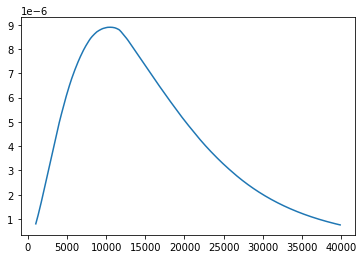

In [19]:
x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
p = model(x) 
plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p.cpu().detach().numpy() / SCALING_CONSTANT)

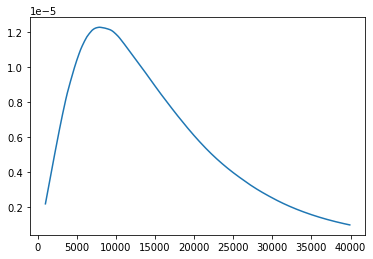

In [20]:
x = torch.Tensor(np.arange(0.1, 4 , 0.01)).to(device).unsqueeze(-1)
p_eq = model_eq(x)
plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p_eq.cpu().detach().numpy() / SCALING_CONSTANT)

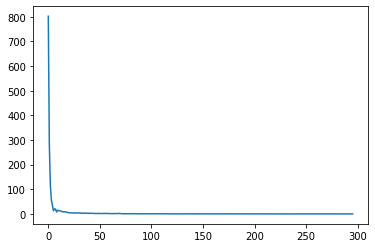

In [21]:
plt.plot(range(len(loss_history)), loss_history)

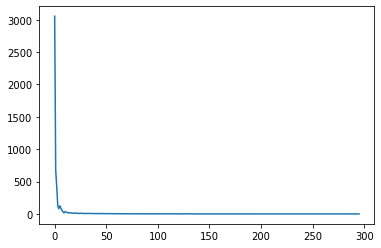

In [22]:
plt.plot(range(len(loss_history_eq)), loss_history_eq)

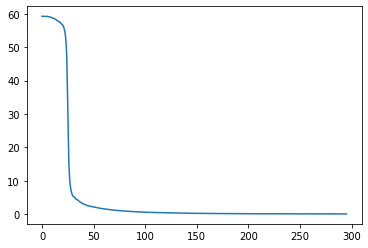

In [23]:
running_loss_average = uniform_filter1d(loss_history, size=50)
plt.plot(range(len(running_loss_average[-300:])), running_loss_average[-300:])

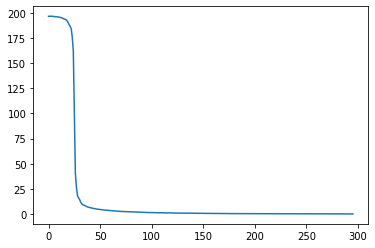

In [24]:
running_loss_average_eq = uniform_filter1d(loss_history_eq, size=50)
plt.plot(range(len(running_loss_average_eq)), running_loss_average_eq)

In [25]:
x = torch.Tensor(np.arange(0.001, 20, 0.01)).to(device).unsqueeze(-1)
p = np.array(model(x).detach())
print(np.argmax(p)*0.01*SCALING_CONSTANT)

10500.0
